In [2]:
import os
import sys
py_files_dir = os.path.abspath("../../py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import instrument_matrices as matrices
import pandas as pd
import numpy as np
import helper_functions as funcions

# Setting Up Initial Instrument Parameters

In [3]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

model = matrices.full_system_mueller_matrix

# For testing ideal parameters
# delta_FLC = 0.5
# em_gain = 1
# epsilon_opts = 0 # Made this zero for testing purposes

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Using Normalized Double Differences as the Observable

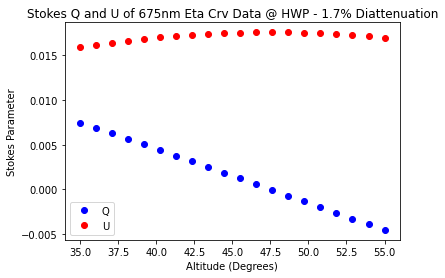

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Setting initial altitudes
wavelength = 675
first_rows = []
diffs_and_sums = []
Q_list = []
U_list = []
final_altitudes = []
full_inst_matrices_list = []
inst_matrices_at_HWP = []
diffs = []
this_cycle_altitudes = []

# Load altitudes and IMR_angs from files
altitudes = np.load("../../../data/unpolarized/numpy/Eta_Crv_double_diff_and_sum_altitudes.npy")
IMR_angs = np.load("../../../data/unpolarized/numpy/Eta_Crv_double_diff_and_sum_IMR_angs.npy")
altitudes = np.linspace(35, 55, 20)
HWP_angs = np.array([0, 45, 22.5, 67.5])

# Loop through each target and calculate s_sky individually
for i, altitude in enumerate(altitudes):
    for j, HWP_ang in enumerate(HWP_angs):
        epsilon_m3 = 0.0176  # Re-instating epsilon_m3 value after reconstruction at HWP
        offset_m3 = -2.55
        fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
                        delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
                        rot_FLC, em_gain]
        # 0 parallactic angle
        full_inst_matrices = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
            model, fixed_params, 0, altitude, HWP_angs[j], IMR_angs[i])
        full_double_diff_matrix = full_inst_matrices[0]
        full_double_sum_matrix = full_inst_matrices[1]
        full_inst_matrices_list.append(full_double_diff_matrix)
        full_inst_matrices_list.append(full_double_sum_matrix)

        # Make a fake "measurement" with s_out = output Stokes
        s_in = np.array([[1], [0], [0], [0]])
        s_out_diff = full_double_diff_matrix @ s_in
        s_out_sum = full_double_sum_matrix @ s_in

        # Saving the propagated double diffs and sums
        this_double_diff = s_out_diff[0][0]
        this_double_sum = s_out_sum[0][0]
        diffs.append(this_double_diff)
        diffs_and_sums.append(this_double_diff)
        diffs_and_sums.append(this_double_sum)

        # Calculate instrument matrix at HWP
        # NOTE: Altitude and parallactic angle are 0
        epsilon_m3 = 0  # Re-instating epsilon_m3 value after reconstruction at HWP
        offset_m3 = 0
        fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
                        delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
                        rot_FLC, em_gain]
        these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum( 
            model, fixed_params, 0, 0, HWP_ang, IMR_angs[i])
        double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
        double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

        # Setting the I component to be 1
        double_diff_matrix_at_HWP[0, 0] = 1

        # Saving instrument matrices
        inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
        inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

        # Take only the first row and I, Q, U, components (no V)
        first_rows.append(double_diff_matrix_at_HWP[0, : 3])  
        # first_rows.append(double_sum_matrix_at_HWP[0, : ])  

        # Track altitudes for mean calculation
        this_cycle_altitudes.append(altitude)

    # Constructing measurement matrix to reconstruct Stokes vector at HWP
    measurement_matrix = np.vstack(first_rows)
    measurements = np.array(diffs).reshape(-1, 1)  # Reshape total counts to a column vector

    # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
    s_HWP = np.linalg.pinv(measurement_matrix) @ measurements

    # Extract Q and U from s_HWP_normalized
    Q = s_HWP[1]
    U = s_HWP[2]

    # Append Q, U, altitude to the lists
    Q_list.append(Q)
    U_list.append(U)

    # Saving the mean of the altitudes
    mean_altitude = np.mean(this_cycle_altitudes)
    final_altitudes.append(mean_altitude)

    # Reset measurement matrix rows and double diff and sum measurements
    first_rows = []  
    diffs = []
    this_cycle_altitudes = []

# Convert lists to numpy arrays for plotting
Q_list = np.array(Q_list).flatten()
U_list = np.array(U_list).flatten()
final_altitudes = np.array(final_altitudes)

# Plotting the data
plt.plot(final_altitudes, Q_list, label='Q', linestyle='None', marker='o', color='blue')
plt.plot(final_altitudes, U_list, label='U', linestyle='None', marker='o', color='red')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - 1.7% Diattenuation")
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes Parameter")
plt.legend() 
plt.show()


# Printing Instrumental Matrices

In [5]:
print("Example Double Difference Matrices")
print(inst_matrices_at_HWP[-4])
print(inst_matrices_at_HWP[-2])
print("Example Double Sum Matrices")
print(inst_matrices_at_HWP[-3])
print(inst_matrices_at_HWP[-1])


Example Double Difference Matrices
[[ 1.          0.29324061 -1.04883429  0.3776136 ]
 [-0.01323143 -0.11890361  0.42528277 -0.15311528]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 1.         -0.05222458  1.03951149  0.49530183]
 [-0.01323143  0.02117609 -0.42150255 -0.20083567]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Example Double Sum Matrices
[[ 1.4161659  -0.02204233  0.05979887  0.30558829]
 [-0.56014572  0.05288826 -0.24923001 -0.78172053]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
[[ 1.4161659   0.14381766 -0.07535558  0.26661581]
 [-0.56014572 -0.35949177  0.28871286 -0.68074246]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]


# Testing Mueller Matrices

In [7]:
delta_m3 = 0 # (waves) - assumed to be zero for now
epsilon_m3 = 0  # Rough value from unpolarized standards fit
offset_m3 = 0  # NOTE: Made this zero too for testing purposes
em_gain = 0.423  # Add your actual em_gain value
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163  # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

HWP_ang = 0
IMR_ang = 0
FLC_state = 1

print("HWP Angle: " + str(HWP_ang))
print("IMR Angle: " + str(IMR_ang))
print("FLC State: " + str(FLC_state))
print("Altitude: 0")

test_matrix_1 = model( 
    *fixed_params, 0, 0, HWP_ang, IMR_ang, 1, FLC_state)

print("Test Matrix (Cam 1): " + str(test_matrix_1))

test_matrix_2 = model( 
    *fixed_params, 0, 0, HWP_ang, IMR_ang, 2, FLC_state)

print("Test Matrix (Cam 2): " + str(test_matrix_2))

test_double_diff_and_sum_matrices = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum( 
    model, fixed_params, 0, 0, HWP_ang, IMR_ang)
test_double_diff_matrix = test_double_diff_and_sum_matrices[0]
test_double_sum_matrix = test_double_diff_and_sum_matrices[1]

print("Test Matrix (DD): " + str(test_double_diff_matrix))
print("Test Matrix (DS): " + str(test_double_sum_matrix))

HWP Angle: 0
IMR Angle: 0
FLC State: 1
Altitude: 0
Test Matrix (Cam 1): [[ 0.21885504 -0.19890723  0.08763397  0.02556812]
 [ 0.21885504 -0.19890723  0.08763397  0.02556812]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Test Matrix (Cam 2): [[ 0.4826122   0.43636911 -0.19982076 -0.05067737]
 [-0.4826122  -0.43636911  0.19982076  0.05067737]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.        ]]
Test Matrix (DD): [[ 3.26314075e-02 -1.08003320e+00 -8.25599710e-04 -4.02694751e-01]
 [-1.32314281e-02  4.37933348e-01  3.34765308e-04  1.63285222e-01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]]
Test Matrix (DS): [[ 1.4161659   0.0369904  -0.22470834 -0.21350373]
 [-0.56014572 -0.19051948  0.57573508  0.55518574]
 [ 0.          0.          0.          0.        ]
 [ 0.          0.          0.          